In [22]:
!pip install transformers datasets evaluate scikit-learn matplotlib seaborn torch -q

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import RobertaTokenizerFast, RobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import random

# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [24]:
class FinancialSentimentDataset(TorchDataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.texts)

    def preprocess_text(self, text):
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\$[\d,]+\.?\d*', '[MONEY]', text)
        text = re.sub(r'\d+\.?\d*%', '[PERCENT]', text)
        text = re.sub(r'EUR?\d+', '[CURRENCY]', text)
        return text.strip()

    def augment_text(self, text, ratio=0.05):
        if not self.augment or random.random() > 0.3:
            return text
        words = text.split()
        n_augmented = max(1, int(len(words)*ratio))
        for _ in range(n_augmented):
            if len(words) > 3:
                idx = random.randint(0, len(words)-1)
                if random.random() > 0.5:
                    words.pop(idx)
        return ' '.join(words)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        text = self.preprocess_text(text)
        if self.augment:
            text = self.augment_text(text)
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label, dtype=torch.long)}

print("Dataset class defined.")


Dataset class defined.


In [25]:
class FinancialSentimentClassifier(nn.Module):
    def __init__(self, num_labels=3, dropout=0.2):
        super().__init__()
        self.bert = RobertaModel.from_pretrained("roberta-base")
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = outputs.last_hidden_state
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * attention_mask_expanded, 1)
        sum_mask = torch.clamp(attention_mask_expanded.sum(1), min=1e-9)
        pooled_output = sum_embeddings / sum_mask
        return self.classifier(pooled_output)

print("Model class defined.")


Model class defined.


In [26]:
import torch.nn.functional as F

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing=smoothing

    def forward(self, pred, target):
        n_class = pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        one_hot = one_hot * (1 - self.smoothing) + (1 - one_hot) * self.smoothing / (n_class - 1)
        log_prob = F.log_softmax(pred, dim=1)
        return -(one_hot * log_prob).sum(dim=1).mean()

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            self.should_stop = True
        return self.should_stop
print("Label smoothing loss and early stopping defined.")


Label smoothing loss and early stopping defined.


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_df = pd.read_csv("data.csv")
sentiment_map = {'negative':0, 'neutral':1, 'positive':2}
data_df['label'] = data_df['Sentiment'].map(sentiment_map)
data_df = data_df.dropna(subset=['label'])

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data_df['Sentence'].values, data_df['label'].values, test_size=0.3, random_state=42, stratify=data_df['label'])
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
train_dataset = FinancialSentimentDataset(train_texts, train_labels, tokenizer, augment=True)
val_dataset = FinancialSentimentDataset(val_texts, val_labels, tokenizer)
test_dataset = FinancialSentimentDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data loaded and DataLoaders created.")


Using device: cuda
Data loaded and DataLoaders created.


In [28]:
model = FinancialSentimentClassifier()
model.to(device)

class_counts = np.bincount(train_labels)
class_weights = len(train_labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
total_steps = len(train_loader) * 6
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
early_stopping = EarlyStopping(patience=3)

print("Model, optimizer, criterion, scheduler initialized.")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model, optimizer, criterion, scheduler initialized.


In [29]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(dataloader), correct / total

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    return total_loss / len(dataloader), correct / total, all_preds, all_labels

print("Training and evaluation functions ready.")


Training and evaluation functions ready.


In [30]:
epochs = 6
best_val_acc = 0
best_model_state = None
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    val_loss, val_acc, val_preds, val_labels = evaluate_model(model, val_loader, criterion, device)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}\n")
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
    if early_stopping(val_loss):
        print("Early stopping triggered.")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)

print("Training completed.")


Epoch 1/6
Train loss: 0.9213, Train acc: 0.6211
Val loss: 0.7425, Val acc: 0.7934

Epoch 2/6
Train loss: 0.6914, Train acc: 0.8050
Val loss: 0.7456, Val acc: 0.7900

Epoch 3/6
Train loss: 0.6380, Train acc: 0.8337
Val loss: 0.7176, Val acc: 0.8139

Epoch 4/6
Train loss: 0.5760, Train acc: 0.8684
Val loss: 0.7156, Val acc: 0.8311

Epoch 5/6
Train loss: 0.5455, Train acc: 0.8875
Val loss: 0.7190, Val acc: 0.7820

Epoch 6/6
Train loss: 0.5265, Train acc: 0.8995
Val loss: 0.7354, Val acc: 0.7831

Training completed.


Test loss: 0.7173, Test accuracy: 0.8107


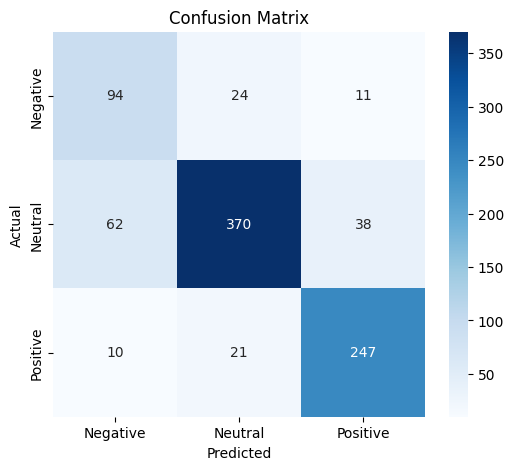

Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.73      0.64       129
     Neutral       0.89      0.79      0.84       470
    Positive       0.83      0.89      0.86       278

    accuracy                           0.81       877
   macro avg       0.76      0.80      0.78       877
weighted avg       0.83      0.81      0.81       877



In [31]:
test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

class_names = ['Negative', 'Neutral', 'Positive']
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))


In [32]:
def predict_sentiment(text, model, tokenizer, device):
    model.eval()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\$[\d,]+\.?\d*', '[MONEY]', text)
    text = re.sub(r'\d+\.?\d*%', '[PERCENT]', text)
    text = re.sub(r'EUR?\d+', '[CURRENCY]', text)
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)

    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_class].item()

    labels_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return labels_map[pred_class], confidence

sentence = "The company reported strong quarterly earnings and growth."
label, conf = predict_sentiment(sentence, model, tokenizer, device)
print(f"Sentence: {sentence}\nPredicted sentiment: {label} (Confidence: {conf:.2f})")


Sentence: The company reported strong quarterly earnings and growth.
Predicted sentiment: Positive (Confidence: 0.91)
